In [1]:
from pathlib import Path
import pandas as pd
import os
import cdsapi
import torch
import xarray as xr
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download

from aurora import Batch, Metadata, Aurora, rollout

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DAY_START = pd.Timestamp("2025-10-13")
DAY_END = pd.Timestamp("2025-10-14")

DOWNLOAD_PATH = Path("../data/era5")
DOWNLOAD_PATH.mkdir(parents=True, exist_ok=True)

# Download all relevant ERA5 inputs for Aurora
Can download 1GB+ of data, depending on date range

In [4]:
c = cdsapi.Client(sleep_max=10)

def download_static():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "geopotential",
                "land_sea_mask",
                "soil_type",
            ],
            "year": "2023", # doesn't matter, doesn't change
            "month": "01",
            "day": "01",
            "time": "00:00",
            "format": "netcdf",
        },
        str(DOWNLOAD_PATH / "static.nc"),
    )
    print("Static variables downloaded!")

def download_data(file_name: Path, data_source, vars, pressure_levels, time=["00:00", "06:00", "12:00", "18:00"]):
    params = {
            "product_type": "reanalysis",
            "variable": vars,
            "year": str(DAY_START.year),
            "month": str(DAY_START.month).zfill(2),
            "day": [str(date.day).zfill(2) for date in pd.date_range(DAY_START, DAY_END, freq="D")],
            "time": time,
            "format": "netcdf",
        }
    if pressure_levels:
        params["pressure_level"] = pressure_levels

    file_name.parent.mkdir(parents=True, exist_ok=True)
    c.retrieve(
        data_source,
        params,
        str(file_name),
    )

In [5]:
if not (DOWNLOAD_PATH / "static.nc").exists():
   download_static()

#Download the surface-level variables.
surface_path = DOWNLOAD_PATH / "surf_vars" / f"{DAY_START.strftime('%Y-%m-%d')}_{DAY_END.day}-surface-level.nc"
if not surface_path.exists():
    download_data(surface_path, "reanalysis-era5-single-levels", ["2m_temperature", "10m_u_component_of_wind", "10m_v_component_of_wind", "mean_sea_level_pressure"], None)
    print("Surface-level variables downloaded!")

# Download the atmospheric variables.
atmos_path = DOWNLOAD_PATH / "atmos_vars" / f"{DAY_START.strftime('%Y-%m-%d')}_{DAY_END.day}-atmospheric.nc"
if not atmos_path.exists():
    download_data(atmos_path, "reanalysis-era5-pressure-levels", 
                  ["temperature", "u_component_of_wind", "v_component_of_wind", "specific_humidity", "geopotential"], 
                  ["50", "100", "150", "200", "250", "300", "400", "500", "600", "700", "850", "925", "1000"])
    print("Atmospheric variables downloaded!")

# Download some ground truth to check interpolation against

In [7]:
def download_era5_day(variable: str, timestamp: pd.Timestamp, filename:str):
        """
        Make a request to Copernicus. 
        Can only request one variable at a time for now, as it will otherwise zip them
        """
        request = {
            "product_type": ["reanalysis"],
            "variable": [variable],
            "year": [str(timestamp.year)],
            "month": [str(timestamp.month).zfill(2)],
            "day": [str(timestamp.day).zfill(2)],
            "time": [
                "00:00",
                "01:00",
                "02:00",
                "03:00",
                "04:00",
                "05:00",
                "06:00",
                "07:00",
                "08:00",
                "09:00",
                "10:00",
                "11:00",
                "12:00",
                "13:00",
                "14:00",
                "15:00",
                "16:00",
                "17:00",
                "18:00",
                "19:00",
                "20:00",
                "21:00",
                "22:00",
                "23:00",
            ],
            "data_format": "netcdf",
            "download_format": "unarchived",
        }
        c.retrieve(
            "reanalysis-era5-single-levels", request, target=filename
        )

variable = "2m_temperature"
filename = f"../data/era5/{variable}_control.nc"
if not os.path.exists(filename):
    download_era5_day(variable, DAY_START)

# Convert data to batch for Aurora

In [8]:
static_vars_ds = xr.open_dataset(DOWNLOAD_PATH / "static.nc", engine="netcdf4")
surf_vars_ds = xr.open_dataset(surface_path, engine="netcdf4")
atmos_vars_ds = xr.open_dataset(atmos_path, engine="netcdf4")

In [9]:
batch = Batch(
    surf_vars={
        # First select the first two time points: 00:00 and 06:00. Afterwards, `[None]`
        # inserts a batch dimension of size one.
        "2t": torch.from_numpy(surf_vars_ds["t2m"].values[:2][None]),
        "10u": torch.from_numpy(surf_vars_ds["u10"].values[:2][None]),
        "10v": torch.from_numpy(surf_vars_ds["v10"].values[:2][None]),
        "msl": torch.from_numpy(surf_vars_ds["msl"].values[:2][None]),
    },
    static_vars={
        # The static variables are constant, so we just get them for the first time.
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars={
        "t": torch.from_numpy(atmos_vars_ds["t"].values[:2][None]),
        "u": torch.from_numpy(atmos_vars_ds["u"].values[:2][None]),
        "v": torch.from_numpy(atmos_vars_ds["v"].values[:2][None]),
        "q": torch.from_numpy(atmos_vars_ds["q"].values[:2][None]),
        "z": torch.from_numpy(atmos_vars_ds["z"].values[:2][None]),
    },
    metadata=Metadata(
        lat=torch.from_numpy(surf_vars_ds.latitude.values),
        lon=torch.from_numpy(surf_vars_ds.longitude.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        # one value for every batch element. Select element 1, corresponding to time
        # 06:00.
        time=(surf_vars_ds.valid_time.values.astype("datetime64[s]").tolist()[1],),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.pressure_level.values),
    ),
)

# Setup Aurora Model & Inference

In [10]:
model = Aurora(use_lora=False)  # The pretrained version does not use LoRA.
model.load_checkpoint(name="aurora-0.25-pretrained.ckpt")

model.eval()
model = model.to("cuda")
print("Num parameters: ", sum([p.numel() for p in model.parameters()]))

aurora-0.25-pretrained.ckpt:   0%|          | 0.00/5.03G [00:00<?, ?B/s]

Num parameters:  1256300176


In [11]:
with torch.inference_mode():
        steps = surf_vars_ds["t2m"].shape[0] - 1 # we already have first two, but want also include end bound for interpolation
        preds = [pred.to("cpu") for pred in rollout(model, batch, steps=steps)]

In [12]:
len(preds)

7

In [36]:
import sys
sys.path.append("../")
from backend.prediction import Prediction
from scipy.interpolate import PchipInterpolator

def hermit_interp(data: np.ndarray, prefix: int, step_size=6) -> np.ndarray:
        """
        Interpolates a tensor with 6-hourly timestamps to hourly resolution
        using Piecewise Cubic Hermite Interpolating Polynomial (PCHIP).
        # NOTE: last hour of data is only for interpolation purposes and truncated

        Args:
            data (np.ndarray): The input data tensor with shape (x, 721, 1440).
            prefix (int): Number of initial hours to skip in the output.

        Returns:
            np.ndarray: The interpolated data tensor with shape (step_size * (x-prefix) - 1, 721, 1440).
        """
        # Original times: 0, 6, 12, ..., 246 hours (41 * 6)
        t_original = np.arange(data.shape[0]) * step_size

        # New times: 0, 1, 2, ..., 246 hours.
        t_new = np.arange(t_original[-1] + 1)

        interpolator = PchipInterpolator(t_original, data, axis=0)

        data_hourly = interpolator(t_new)
        # remove first (couple) and last datapoint (only there for interpolation)
        start_preds = (prefix - 1) * step_size + 1
        return data_hourly[start_preds:-1]

# NOTE: Works
def _post_process_generic(data, add_first_row=True):
        # aurora post-process
        # Make latitude go from -87.5 to 90.0 instead of decreasing order
        # duplicate the first row for a -90.0 prediction
        data = data.squeeze().flip(dims=(-2,))
        if add_first_row:
            data = torch.cat((data[0].unsqueeze(0), data))
        return data


def process_prediction(batch: Batch, preds) -> Prediction:
        # also include last of batch, so that interpolation for first 6 hours is possible
        temp_preds = [_post_process_generic(batch.surf_vars["2t"][:, i], add_first_row=False) for i in [0, 1]]

        for pred in preds:
            temp_preds.append(_post_process_generic(pred.surf_vars["2t"]))  

        return Prediction(
            temperature = hermit_interp(torch.stack(temp_preds, dim=0).numpy(), prefix=2)
        )  

def rmse(a,b):
      return np.sqrt(((np.asarray(a) - np.asarray(b)) ** 2).mean())        

In [37]:
gt = xr.open_dataset("../data/era5/2m_temperature_control.nc", engine="netcdf4")
gt_data = _post_process_generic(torch.Tensor(gt["t2m"].to_numpy()), add_first_row=False)

In [38]:
pred_data = process_prediction(batch, preds)
assert len(pred_data.temperature) == len(surf_vars_ds["t2m"]) * 6 - 7
print(f"We now have predicted for {len(pred_data.temperature)} hours.")

We now have predicted for 41 hours.


## Sanity check if hour 0 and hour 6 are same in both datasets for t2m

In [28]:
((gt_data[0] - _post_process_generic(batch.surf_vars["2t"][:, 0], add_first_row=False)) ** 2).mean().sqrt()

tensor(0.)

In [29]:
((gt_data[6] - _post_process_generic(batch.surf_vars["2t"][:, 1], add_first_row=False)) ** 2).mean().sqrt()

tensor(0.)

## Plot performance for all predicted hours -- including the Hermit interpolation

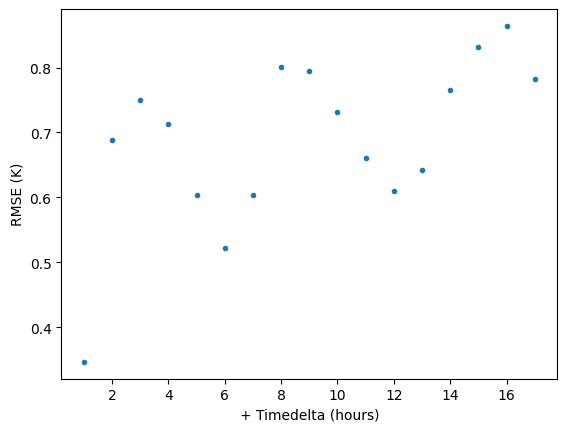

In [39]:
rmses = []
offset = 7
for i in range(offset, len(gt_data)):
    gt_data_slice = gt_data[i]
    rmses.append(rmse(pred_data.temperature[i - offset], gt_data_slice))

plt.plot(np.arange(1, len(gt_data) - offset + 1), rmses, ".")
plt.ylabel("RMSE (K)")
plt.xlabel("+ Timedelta (hours)");